# Homework 4 - Evaluation Metrics

In this homework, we will use the lead scoring dataset Bank Marketing dataset. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Download the data
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data Preparation
- missing values
    - for categorical, replace with 'NA'
    - for numerical, replace with 0.0
- train/validation/test split

## Fill missing values

In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
# get columns with type object
categorical = df.columns[df.dtypes == 'object'].to_list()
numerical = df.columns[df.dtypes != 'object'].to_list()
# remove target variable from numerical features
numerical.remove('converted')
print("categorical: ", categorical)
print("numerical: ", numerical)

categorical:  ['lead_source', 'industry', 'employment_status', 'location']
numerical:  ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [6]:
# replace NA with 'NA' for categorical features
df[categorical] = df[categorical].fillna('NA')
df[categorical]


,lead_source,industry,employment_status,location
0,paid_ads,NA,unemployed,south_america
1,social_media,retail,employed,south_america
2,events,healthcare,unemployed,australia
3,paid_ads,retail,NA,australia
4,referral,education,self_employed,europe
...,...,...,...,...
1457,referral,manufacturing,self_employed,north_america
1458,referral,technology,student,europe
1459,paid_ads,technology,student,north_america
1460,referral,NA,self_employed,north_america


In [7]:
# replace NA with 0.0 for numerical features
df[numerical] = df[numerical].fillna(0.0)
df[numerical]

,number_of_courses_viewed,annual_income,interaction_count,lead_score
0,1,79450.0,4,0.94
1,1,46992.0,1,0.80
2,5,78796.0,3,0.69
3,2,83843.0,1,0.87
4,3,85012.0,3,0.62
...,...,...,...,...
1457,1,0.0,4,0.53
1458,3,65259.0,2,0.24
1459,1,45688.0,3,0.02
1460,5,71016.0,0,0.25


## Train-Validation split

In [8]:
from sklearn.model_selection import train_test_split 

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 25% is 20% of 80% (train_val)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [11]:
y_train = df_train['converted'].to_numpy()
y_val = df_val['converted'].to_numpy()
y_test = df_test['converted'].to_numpy()

In [12]:
# drop target variable
del df_train['converted']
del df_val['converted']
del df_test['converted']

# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that:

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc # this is for any curve, not just ROC
from sklearn.metrics import roc_auc_score


In [14]:
for var in numerical:
    y_pred = df_train[var].values
    print(var, ':', roc_auc_score(y_train, y_pred))

number_of_courses_viewed : 0.763839852937201
annual_income : 0.5235624881727988
interaction_count : 0.7253683328377173
lead_score : 0.6277716201238139


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [18]:
roc_auc_score(y_val, y_pred)

0.8082519332519332

In [19]:
from sklearn.metrics import roc_curve

In [20]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

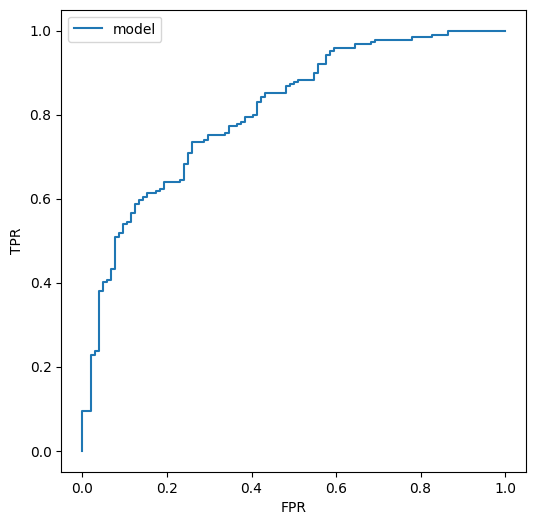

In [21]:
# Plot FPR vs TPR
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr ,label='model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


In [ ]:
auc(fpr, tpr) 

0.11174806674806681

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01.

For each threshold, compute precision and recall.

Plot them.


In [26]:
def tpr_fpr_dataframe(y_val,y_pred):
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # true positive
        tp = (predict_positive & actual_positive).sum()
        # true negative
        tn = (predict_negative & actual_negative).sum()

        # false positives
        fp = (predict_positive & actual_negative).sum()
        # false negatives
        fn = (predict_negative & actual_positive).sum()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

        # true positive rate: TPR = TP/(TP+FN) - same as recall
        tpr = tp/(tp+fn)
        # false positive rate: FPR = FP/(TN+FP)
        fpr = fp/(tn+fp)
        scores.append({'threshold':t, 'tp': tp, 'tn': tn, 
                       'fp': fp, 'fn': fn, 'tpr': tpr, 'fpr': fpr,
                       'precision': precision, 'recall': recall})

    df_scores = pd.DataFrame(scores)

    return df_scores

In [27]:
df_scores = tpr_fpr_dataframe(y_val,y_pred)
df_scores[::10]

/var/folders/61/s_79sg457g366qq6yphwml740000gn/T/ipykernel_21437/1787707221.py:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


,threshold,tp,tn,fp,fn,tpr,fpr,precision,recall
0,inf,0,104,0,189,0.000000,0.000000,NaN,0.000000
10,0.864075,76,99,5,113,0.402116,0.048077,0.938272,0.402116
20,0.794482,102,94,10,87,0.539683,0.096154,0.910714,0.539683
30,0.723727,114,89,15,75,0.603175,0.144231,0.883721,0.603175
40,0.686761,122,80,24,67,0.645503,0.230769,0.835616,0.645503
50,0.624247,142,73,31,47,0.751323,0.298077,0.820809,0.751323
60,0.587397,150,64,40,39,0.793651,0.384615,0.789474,0.793651
70,0.516111,164,54,50,25,0.867725,0.480769,0.766355,0.867725
80,0.441857,174,46,58,15,0.920635,0.557692,0.750000,0.920635
90,0.347853,184,33,71,5,0.973545,0.682692,0.721569,0.973545


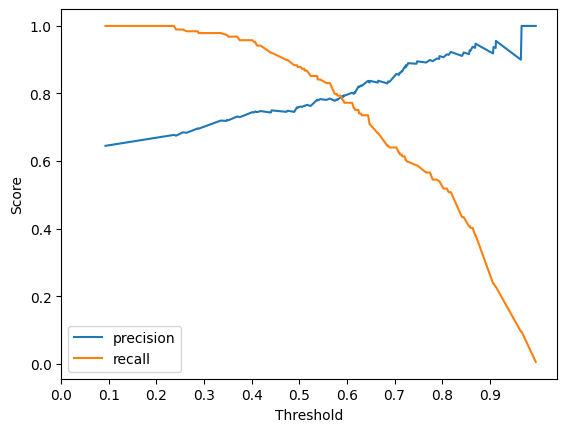

In [28]:
#plot scores
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
# add y axis labels
plt.xlabel('Threshold')
plt.ylabel('Score')
# add more ticks
plt.xticks(np.arange(0, 1, step=0.1))
plt.legend()
plt.show()


In [29]:
line1 = np.array(list(zip(df_scores.threshold, df_scores.precision)))
line2 = np.array(list(zip(df_scores.threshold, df_scores.recall)))

#  Calculate the point of intersection
intersection = line1.dot(line2.T) / np.linalg.norm(line1)

print("Intersection of the two lines is:", intersection)

Intersection of the two lines is: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


# Question 4: F1 Score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
precision and recall:

### F1 = 2 * (precision * recall) / (precision + recall)

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [37]:
# array from 0.0 to inclusive 1.0 with increment 0.01
thresholds = np.arange(0.0, 1.01, 0.01)  
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [44]:
from sklearn.metrics import f1_score


def tpr_fpr_dataframe(y_val,y_pred, thresholds):
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # true positive
        tp = (predict_positive & actual_positive).sum()
        # true negative
        tn = (predict_negative & actual_negative).sum()

        # false positives
        fp = (predict_positive & actual_negative).sum()
        # false negatives
        fn = (predict_negative & actual_positive).sum()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

        f1_score = 2*precision*recall/(precision+recall)

        scores.append({'threshold':t, 'f1_score': f1_score,
                       'precision': precision, 'recall': recall})


    df_scores = pd.DataFrame(scores)

    return df_scores

In [45]:
df_scores = tpr_fpr_dataframe(y_val,y_pred, thresholds)

/var/folders/61/s_79sg457g366qq6yphwml740000gn/T/ipykernel_21437/1407521504.py:24: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [46]:
df_scores

,threshold,f1_score,precision,recall
0,0.00,0.784232,0.645051,1.000000
1,0.01,0.784232,0.645051,1.000000
2,0.02,0.784232,0.645051,1.000000
3,0.03,0.784232,0.645051,1.000000
4,0.04,0.784232,0.645051,1.000000
...,...,...,...,...
96,0.96,0.198113,0.913043,0.111111
97,0.97,0.156098,1.000000,0.084656
98,0.98,0.081218,1.000000,0.042328
99,0.99,0.041451,1.000000,0.021164


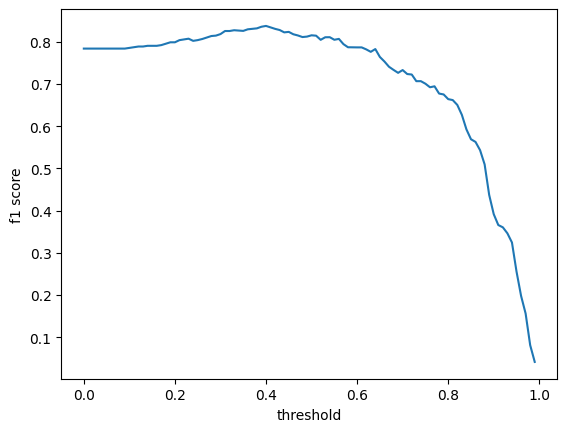

In [51]:
# plot f1 score from df_scores
plt.plot(df_scores['threshold'], df_scores['f1_score'], label='f1 score')
# add x axis label
plt.xlabel('threshold') 
# add y axis label
plt.ylabel('f1 score')
plt.show()

In [56]:
# get max f1 score
row_with_max_value = df_scores.loc[df_scores['f1_score'].idxmax()]
row_with_max_value


threshold    0.400000
f1_score     0.837963
precision    0.744856
recall       0.957672
Name: 40, dtype: float64

# Question 5: Cross-Validation
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

In [57]:
# K-Fold Cross Validation
from sklearn.model_selection import KFold

In [58]:
KFold(n_splits=5, shuffle=True, random_state=1)

KFold(n_splits=5, random_state=1, shuffle=True)

In [59]:
from tqdm.auto import tqdm

/Users/juliastache/Desktop/Courses/ml-zoomcamp/ml-zoomcamp/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
n_splits = 5


# find the best regularization parameter
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = [] 

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # returns indexes for the training set and for the validation set - loop over the generator
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        #train
        dicts = df_train[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)

        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train, y_train)

        #predict
        dicts = df_val[categorical + numerical].to_dict(orient='records')

        X = dv.transform(dicts) # do not fit again! this was done in training
        y_pred = model.predict_proba(X)[:,1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f.+-%.3f' % (C, np.mean(scores), np.std(scores)))


 43%|████▎     | 3/7 [00:00<00:00, 22.29it/s]

C=0.001 0.827.+-0.035
C=0.01 0.827.+-0.035
C=0.1 0.827.+-0.035
C=0.5 0.827.+-0.035
C=1 0.827.+-0.035


100%|██████████| 7/7 [00:00<00:00, 23.51it/s]

C=5 0.827.+-0.035
C=10 0.827.+-0.035


In [66]:
np.std(scores)

np.float64(0.03529771110727888)

# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]. 
Initialize KFold with the same parameters as previously  
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000) 
Compute the mean score as well as the std (round the mean and std to 3 decimal digits) 
Which C leads to the best mean score? 

In [68]:
n_splits = 5

# find the best regularization parameter
for C in tqdm([0.000001, 0.001, 1]):
    scores = [] 

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # returns indexes for the training set and for the validation set - loop over the generator
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        #train
        dicts = df_train[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        #predict
        dicts = df_val[categorical + numerical].to_dict(orient='records')

        X = dv.transform(dicts) # do not fit again! this was done in training
        y_pred = model.predict_proba(X)[:,1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f.+-%.3f' % (C, np.mean(scores), np.std(scores)))


100%|██████████| 3/3 [00:00<00:00, 23.64it/s]

C=1e-06 0.540.+-0.030
C=0.001 0.860.+-0.038
C=1 0.827.+-0.035
